# POKEMON DATABASE - DATA ANALYSIS

> Neste notebook, vamos explorar e analisar uma base de dados completa de Pokémon, extraída de fontes públicas e enriquecida com informações adicionais, como atributos de batalha, habilidades, fraquezas e locais de captura.

O objetivo deste trabalho é aplicar técnicas de análise de dados para responder perguntas relevantes, identificar padrões, tendências e insights que possam ser úteis para jogadores, pesquisadores ou entusiastas do universo Pokémon.

Ao longo do notebook, você encontrará:
- Bibliotecas utilizadas
- Extração, limpeza e preparação dos dados 
- Dicionário de dados
- Análise de qualidade e exploratória dos dados
- Visualizações para facilitar a compreensão dos dados
- Descoberta de relações entre tipos, habilidades, fraquezas e desempenho
- Insights sobre distribuição, raridade e características marcantes dos Pokémon

## Bibliotecas Utilizadas


Para realizar a análise e manipulação dos dados neste notebook, utilizamos as seguintes bibliotecas Python:

- **pandas**  
  Manipulação, limpeza e análise de dados em formato tabular (DataFrames).

- **beautifulsoup4**  
  Extração e parsing de informações de arquivos HTML.

- **requests**  
  Requisições HTTP para acessar APIs e baixar dados da internet (ex: PokeAPI).

- **plotly**  
  Visualizações interativas e dinâmicas (gráficos e tabelas).

- **nbformat**  
  Suporte ao funcionamento de notebooks Jupyter e renderização de gráficos interativos.

- **scipy**  
  Ferramentas estatísticas e científicas, como cálculo de moda, skewness e curtose.

- **kaleido**  
  Exportação de gráficos Plotly para arquivos de imagem (PNG, SVG, etc).

- **seaborn**  
  Visualização estatística de dados, especialmente gráficos de densidade e heatmaps.

- **matplotlib**  
  Criação de gráficos estáticos e customização avançada de visualizações.

- **deap**  
  Implementação de algoritmos evolutivos e genéticos para otimização.

- **tabulate**  
  Exibição de tabelas formatadas no terminal ou em relatórios.

In [ ]:

%pip install pandas
%pip install beautifulsoup4
%pip install requests
%pip install plotly
%pip install nbformat
%pip install scipy
%pip install kaleido
%pip install seaborn
%pip install matplotlib
%pip install deap
%pip install tabulate

## Extração, Limpeza e Preparação dos Dados

O processo de construção da base de dados utilizada nesta análise envolveu diversas etapas de extração, enriquecimento e preparação dos dados, conforme descrito abaixo:

- **Extração Inicial:**  
  A base principal de Pokémon foi extraída do site oficial [Pokédex Pokémon](https://www.pokemon.com/br/pokedex), contendo informações básicas de cada espécie.

- **Enriquecimento com Localização de Captura:**  
  Utilizou-se a [PokeAPI](https://pokeapi.co/) para complementar a base, adicionando as localizações de captura de cada Pokémon, tornando a análise mais rica e detalhada.

- **Resgate de Dados de Status:**  
  Os dados de status dos Pokémon (HP, Attack, Defense, Sp. Attack, Sp. Defense e Speed) foram extraídos do site [Pokémon Database](https://pokemondb.net/pokedex/all) utilizando a biblioteca BeautifulSoup para leitura do HTML.  
  - Para Pokémon com diferentes formas, foi considerado o status da forma padrão/normal.

- **Normalização dos valores:**  
  Para garantir a consistência e facilitar a análise, os valores numéricos de altura (`height`) e peso (`weight`) dos Pokémon foram convertidos para o tipo `float`, representando metros e quilogramas, respectivamente. Além disso, todos os nomes, tipos, habilidades e fraquezas foram padronizados para letras minúsculas, evitando duplicidade de categorias devido a diferenças de capitalização.

- **Codificação de Dados Categóricos:**  
  Para lidar com atributos que possuem múltiplos valores (como habilidades, tipos, fraquezas e locais de captura), foi aplicada a técnica de One Hot Encoding, facilitando a análise e a modelagem dos dados.

Essas etapas garantem uma base de dados consolidada, limpa e pronta para análises mais profundas e visualizações

In [ ]:
import json
import pandas as pd

# Ler o JSON extraindo do site oficial da pokedex
with open('./assets/pokedex-db.json', "r", encoding="utf-8") as f:
    pokedex_data = json.load(f)

# Converter para DataFrame
df = pd.DataFrame(pokedex_data)

print(f"Tamanho do DataFrame: {df.shape}")
print(f"Colunas do DataFrame: {df.columns.tolist()}")

In [ ]:

# Removendo colunas desnecessárias se existirem
if 'number' in df.columns:
    df.drop(columns=['number'], inplace=True)
if 'detailPageURL' in df.columns:
    df.drop(columns=['detailPageURL'], inplace=True)
if 'collectibles_slug' in df.columns:
    df.drop(columns=['collectibles_slug'], inplace=True)
if 'featured' in df.columns:
    df.drop(columns=['featured'], inplace=True)
if 'slug' in df.columns:
    df.drop(columns=['slug'], inplace=True)
if 'ThumbnailAltText' in df.columns:
    df.drop(columns=['ThumbnailAltText'], inplace=True)
if 'ThumbnailImage' in df.columns:
    df.drop(columns=['ThumbnailImage'], inplace=True)
    
# Converter valores das colunas de tipo string para minusculo
df['name'] = df['name'].str.lower()
for col in ['type', 'abilities', 'weakness']:
    df[col] = df[col].apply(lambda x: [i.lower() for i in x] if isinstance(x, list) else x)
     
print(f"Tamanho do DataFrame após remoção de colunas: {df.shape}\n\n")
print(df.head(5))
        

In [ ]:
from bs4 import BeautifulSoup
import json

# Abra e leia o arquivo HTML
with open('./assets/pokemondb-net.html', 'r', encoding='utf-8') as f:
    html = f.read()

soup = BeautifulSoup(html, 'html.parser')

# Encontre a tabela com id="pokedex"
table = soup.find('table', {'id': 'pokedex'})

# Pegue o cabeçalho da tabela
headers = [th.get_text(strip=True) for th in table.find('thead').find_all('th')]

# Descubra o índice da coluna 'Type'
type_index = headers.index('Type')

# Remova 'Type' dos headers
headers.pop(type_index)

# Extraia os dados das linhas
data = []
for row in table.find('tbody').find_all('tr'):
    cols = row.find_all('td')
    if not cols:
        continue

    # Extrai os textos das colunas, exceto 'Type'
    col_texts = [td.get_text(strip=True) for td in cols]
    col_texts.pop(type_index)

    # Tratamento especial para a coluna 'Name'
    name_td = cols[headers.index('Name')]
    name_a = name_td.find('a')
    name = name_a.get_text(strip=True) if name_a else name_td.get_text(strip=True)
    form_small = name_td.find('small')
    form = form_small.get_text(strip=True) if form_small else None

    # Substitui o valor da coluna 'Name' pelo nome extraído
    col_texts[headers.index('Name')] = name

    # Cria o dicionário
    item = dict(zip(headers, col_texts))
    if form:
        item['form'] = form
    data.append(item)
    
# Remover os pokemons repetidos mantendo apenas o que primeiro aparece na lista
unique_data = []
seen_ids = set()
for item in data:
    poke_id = item.get("#")
    if poke_id and poke_id not in seen_ids:
        unique_data.append(item)
        seen_ids.add(poke_id)
 
# Salvar em um arquivo JSON
with open('./outputs/pokemon-stats-db.json', 'w', encoding='utf-8') as f:
    json.dump(unique_data, f, ensure_ascii=False, indent=4)

# Concatenar os dados de 'attack', 'defense', 'hp', 'sp_atk', 'sp_def', 'speed' ao DataFrame df comparando o "id" do df com o "#" do unique_data
for item in unique_data:
    poke_id = item.get("#")
    if poke_id and poke_id.isdigit():
        poke_id = int(poke_id)

        df.loc[df['id'] == poke_id, ['attack', 'defense', 'hp', 'sp_atk', 'sp_def', 'speed', 'total']] = [
            int(item.get('Attack')),
            int(item.get('Defense')),
            int(item.get('HP')),
            int(item.get('Sp. Atk')),
            int(item.get('Sp. Def')),
            int(item.get('Speed')),
            int(item.get('Total'))
        ]
        
    
# Ordenando colunas
df = df[['id', 'name', 'type', 'height', 'weight', 'attack', 'defense', 'hp', 'sp_atk', 'sp_def', 'speed', 'total', 'abilities', 'weakness']]
         
print(f"Tamanho do DataFrame após atualização: {df.shape}\n\n")
print(df.head())  # Exibir as primeiras linhas do DataFrame atualizado

In [ ]:
import requests
import time
import os

# Verificando Cache
if os.path.exists('./outputs/pokemon_capture_locations.json'):
    df_capture_locations = pd.read_json('./outputs/pokemon_capture_locations.json', orient='records')
    df = df.merge(df_capture_locations, on='id', how='outer')
    print("Dados de localizações de captura carregados do cache.")
    
# Resgatando Localizações de Captura 
else:
    def get_capture_locations(number):
        url = f"https://pokeapi.co/api/v2/pokemon/{number}/encounters"
        try:
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                data = response.json()
                
                # Extrai o nome dos locais de captura
                locations = [loc['location_area']['name'] for loc in data]
                # Converte os nomes para minúsculas
                locations = [loc.lower() for loc in locations]
                return locations
            else:
                return []
        except Exception as e:
            return []
    
    # Adicionar coluna para localizações de captura
    df['capture_location'] = None
        
    # Para cada item da base de dados, resgata as localizações de captura
    for index, row in df.iterrows():
        number = row['id']
        locations = get_capture_locations(number)
        print(f"Localizações de captura para o Pokémon número {number}: {locations}")
        df.at[index, 'capture_location'] = locations
        # time.sleep(1)  # Respeitar o limite de requisições

    # Salvar a base apenas com colunas ID e locations para resgatar e evitar fazer requisição novamente
    df_capture_locations = df[['id', 'capture_location']]
    df_capture_locations.to_json('./outputs/pokemon_capture_locations.json', orient='records', force_ascii=False, indent=4)
    

# Salvar 
basicdf = df
df.to_csv('./outputs/pokemon-basic-db.csv', index=False)

print(f"Tamanho do DataFrame atualizado: {df.shape}")
print(df.head())  # Exibir as primeiras linhas do DataFrame atualizado


In [ ]:
# One-hot encoding para cada campo de array

# Garante que os campos de array estejam como listas (caso estejam ausentes)
for col in ['abilities', 'type', 'weakness', 'capture_location']:
    df[col] = df[col].apply(lambda x: x if isinstance(x, list) else [])

# Extrair valores únicos de habilidades, tipos, fraquezas e localizações de captura
abilities_dummies = df['abilities'].explode().str.strip().str.lower().dropna().unique()
type_dummies = df['type'].explode().str.strip().str.lower().dropna().unique()
weakness_dummies = df['weakness'].explode().str.strip().str.lower().dropna().unique()
capture_location_dummies = df['capture_location'].explode().str.strip().str.lower().dropna().unique()

# Para cada habilidade, tipo, fraqueza e localização de captura, cria colunas one-hot verificando se o valor está presente
df_abilities = df['abilities'].apply(lambda x: pd.Series({f'ability_{a}': int(a in x) for a in abilities_dummies}))
df_type = df['type'].apply(lambda x: pd.Series({f'type_{t}': int(t in x) for t in type_dummies}))
df_weakness = df['weakness'].apply(lambda x: pd.Series({f'weakness_{w}': int(w in x) for w in weakness_dummies}))
df_capture_location = df['capture_location'].apply(lambda x: pd.Series({f'location_{l}': int(l in x) for l in capture_location_dummies}))

# Concatenar tudo
df_final = pd.concat([
    df.drop(['abilities', 'type', 'weakness', 'capture_location'], axis=1),
    df_abilities,
    df_type,
    df_weakness,
    df_capture_location
], axis=1)

# Salvar em CSV
df_final.to_csv('./outputs/pokedex-encoded-db.csv', index=False, encoding='utf-8')

print("CSV com one-hot encoding gerado com sucesso!")
print(f"Tamanho do DataFrame final: {df_final.shape}\n\n")
print(df_final.head(5))

## Dicionário de dados

In [ ]:
import plotly.graph_objects as go

# Defina o dicionário de dados
data_dictionary = [
    {"Coluna": "id", "Tipo": "int", "Formato": "Numérico", "Descrição": "Identificador único do Pokémon (inteiro, corresponde ao número oficial na Pokédex)."},
    {"Coluna": "name", "Tipo": "str", "Formato": "Categórico", "Descrição": "Nome do Pokémon."},
    {"Coluna": "type", "Tipo": "list[str]", "Formato": "Categórico (lista)", "Descrição": "Lista de tipos do Pokémon (ex: ['grass', 'poison']). Um Pokémon pode ter um ou dois tipos."},
    {"Coluna": "height", "Tipo": "float", "Formato": "Numérico", "Descrição": "Altura do Pokémon em metros (float, ex: 0.7)."},
    {"Coluna": "weight", "Tipo": "float", "Formato": "Numérico", "Descrição": "Peso do Pokémon em quilogramas (float, ex: 6.9)."},
    {"Coluna": "attack", "Tipo": "int", "Formato": "Numérico", "Descrição": "Valor numérico do atributo de ataque base do Pokémon."},
    {"Coluna": "defense", "Tipo": "int", "Formato": "Numérico", "Descrição": "Valor numérico do atributo de defesa base do Pokémon."},
    {"Coluna": "hp", "Tipo": "int", "Formato": "Numérico", "Descrição": "Valor numérico dos pontos de vida (HP) base do Pokémon."},
    {"Coluna": "sp_atk", "Tipo": "int", "Formato": "Numérico", "Descrição": "Valor numérico do ataque especial base do Pokémon."},
    {"Coluna": "sp_def", "Tipo": "int", "Formato": "Numérico", "Descrição": "Valor numérico da defesa especial base do Pokémon."},
    {"Coluna": "speed", "Tipo": "int", "Formato": "Numérico", "Descrição": "Valor numérico da velocidade base do Pokémon."},
    {"Coluna": "total", "Tipo": "int", "Formato": "Numérico", "Descrição": "Soma total dos atributos base (attack, defense, hp, sp_atk, sp_def, speed) do Pokémon."},
    {"Coluna": "abilities", "Tipo": "list[str]", "Formato": "Categórico (lista)", "Descrição": "Lista de habilidades do Pokémon (ex: ['Overgrow', 'Chlorophyll'])."},
    {"Coluna": "weakness", "Tipo": "list[str]", "Formato": "Categórico (lista)", "Descrição": "Lista de fraquezas do Pokémon, ou seja, tipos contra os quais ele é vulnerável (ex: ['fire', 'ice'])."},
    {"Coluna": "capture_location", "Tipo": "list[str]", "Formato": "Categórico (lista)", "Descrição": "Lista de locais onde o Pokémon pode ser capturado nos jogos (ex: ['kanto-route-2', 'kanto-viridian-forest'])."}
]

# Crie a tabela com plotly
fig = go.Figure(data=[go.Table(
    header=dict(values=["Coluna", "Tipo", "Formato", "Descrição"], fill_color='paleturquoise', align='left'),
    cells=dict(values=[
        [d["Coluna"] for d in data_dictionary],
        [d["Tipo"] for d in data_dictionary],
        [d["Formato"] for d in data_dictionary],
        [d["Descrição"] for d in data_dictionary]
    ], fill_color='lavender', align='left')
)])

fig.update_layout(width=1200, height=600, title="Dicionário de Dados - DataFrame Básico")

## Análise Descritiva dos Dados

### Introdução

Nessa sessão serão realizada análises descritivas que  ajudam a entender o comportamento geral dos dados e as relações entre atributos.

    - Distribuição estatística das variáveis numéricas
    - Histograma e boxplot por atributos
    - Exploração dos tipos de pokemons e suas características
    - Matriz de correlação entre atributos numéricos
    - Análise da distribuição de pokemons por locais de captura

### Estatísticas Descritivas das Variáveis Numéricas

A análise estatística das variáveis numéricas dos Pokémon revela alguns pontos importantes sobre a base de dados:

- **Diversidade física:**  
  O valores de peso (`weight`) apresenta grande variação, com desvios padrão elevados. Isso indica que existem Pokémons extremamente leves, assim como outros muito pesados, refletindo a diversidade do universo Pokémon.

- **Atributos de batalha equilibrados:**  
  As médias dos atributos de batalha (`attack`, `defense`, `hp`, `sp_atk`, `sp_def`, `speed`) estão próximas, sugerindo que a maioria dos Pokémon possui valores relativamente equilibrados nesses quesitos. No entanto, os valores máximos mostram que existem Pokémon com atributos muito acima da média, geralmente lendários ou formas especiais.

- **Maior parte dos pokemons são fracos:**  
  Para muitos atributos, a moda é menor que a média, indicando que a maior parte dos Pokémon possui valores baixos, mas há alguns com valores muito altos que elevam a média.

- **Distribuição assimétrica:**  
  A diferença entre média, mediana e moda em algumas variáveis sugere distribuições assimétricas, com cauda para valores altos (presença de outliers).

In [21]:
import numpy as np
from scipy import stats

# Seleciona as colunas numéricas
numeric_cols = ['height', 'weight', 'attack', 'defense', 'hp', 'sp_atk', 'sp_def', 'speed', 'total']

# Calcula as estatísticas manualmente
stats_dict = {
    "Média": [df[col].mean() for col in numeric_cols],
    "Mediana": [df[col].median() for col in numeric_cols],
    "Moda": [stats.mode(df[col], nan_policy='omit').mode.item() for col in numeric_cols],
    "Mínimo": [df[col].min() for col in numeric_cols],
    "Máximo": [df[col].max() for col in numeric_cols],
    "Desvio Padrão": [df[col].std() for col in numeric_cols],
    "Q1 (25%)": [df[col].quantile(0.25) for col in numeric_cols],
    "Q2 (50%)": [df[col].quantile(0.5) for col in numeric_cols],   # igual à mediana
    "Q3 (75%)": [df[col].quantile(0.75) for col in numeric_cols]
}

# Cria a tabela com plotly
fig = go.Figure(data=[go.Table(
    header=dict(values=["Atributo"] + list(stats_dict.keys()), fill_color='paleturquoise', align='left'),
    cells=dict(values=[
        numeric_cols,
        stats_dict["Média"],
        stats_dict["Mediana"],
        stats_dict["Moda"],
        stats_dict["Mínimo"],
        stats_dict["Máximo"],
        stats_dict["Desvio Padrão"],
        stats_dict["Q1 (25%)"],
        stats_dict["Q2 (50%)"],
        stats_dict["Q3 (75%)"]
    ], fill_color='lavender', align='left', format=[None] + [".2f"]*9)
)])

fig.update_layout(
    width=1400,
    height=600,
    title="Tabela de Estatísticas Descritivas das Variáveis Numéricas"
)

# Salvar a tabela como imagem na pasta ./charts
os.makedirs('./charts', exist_ok=True)
os.makedirs('./charts/descritive', exist_ok=True)
fig.write_image('./charts/descritive/estatisticas_descritivas_pokemon.png')

fig.show()

### Assimetria e Curtose dos Atributos Numéricos dos Pokémon

- **Altura (`height`) e Peso (`weight`):**
  - Apresentam valores extremamente altos de assimetria (6.55 e 4.34) e curtose (72.29 e 23.59), indicando distribuições altamente assimétricas e com caudas longas. Isso significa que a maioria dos Pokémon é pequena/leve, mas existem poucos Pokémon muito grandes e pesados (outliers), como Wailord ou Celesteela.
- **Atributos de batalha (attack, defense, hp, sp_atk, sp_def, speed):**
  - Todos apresentam assimetria positiva, mas moderada, indicando que a maioria dos Pokémon possui valores baixos nesses atributos, com poucos indivíduos com valores muito altos.
  - A curtose é próxima de zero ou levemente positiva para a maioria dos atributos, sugerindo distribuições próximas da normal, mas com leve presença de outliers (Pokémon lendários ou formas especiais).
  - O atributo `hp` se destaca com curtose 6.06, mostrando maior concentração de valores próximos à média, mas com alguns Pokémon com HP muito elevado.
- **Total:**
  - O atributo `total` apresenta assimetria e curtose próximas de zero (-0.09 e -0.80), indicando uma distribuição quase simétrica e levemente platicúrtica (menos caudas que uma normal). Isso sugere que a soma dos atributos é mais equilibrada entre as espécies.
- **Resumo geral:**
  - Os dados confirmam que a maioria dos Pokémon possui atributos físicos e de batalha modestos, com poucos extremos. Altura e peso são os atributos mais desbalanceados, enquanto o total de pontos tende a ser mais distribuído de forma homogênea.

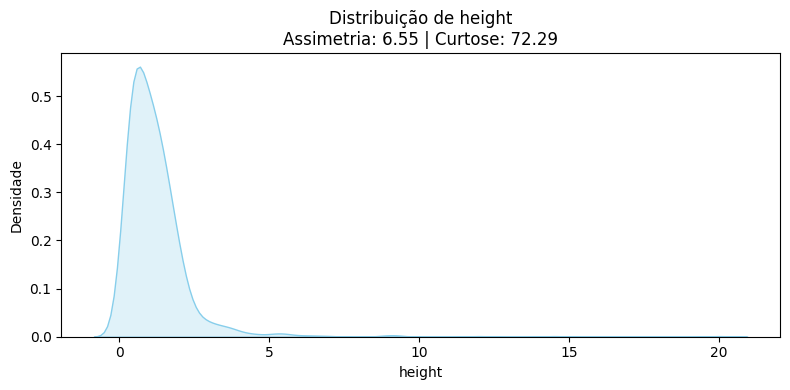

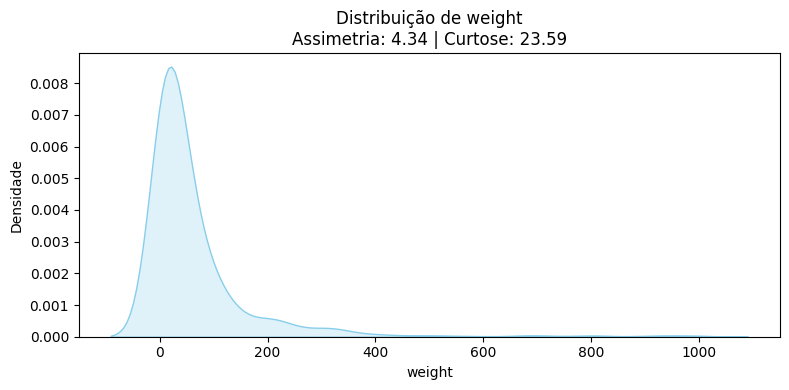

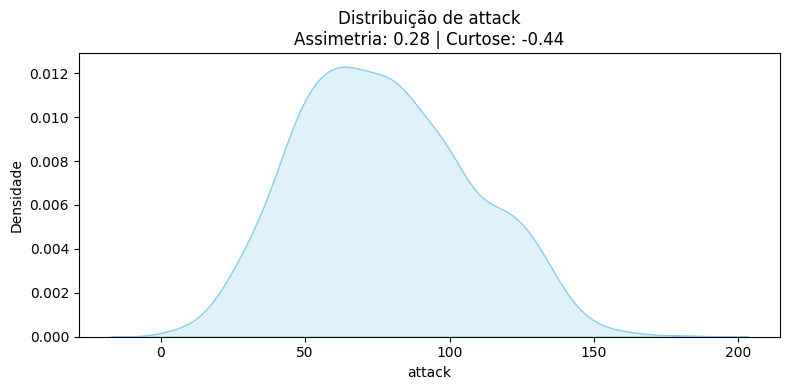

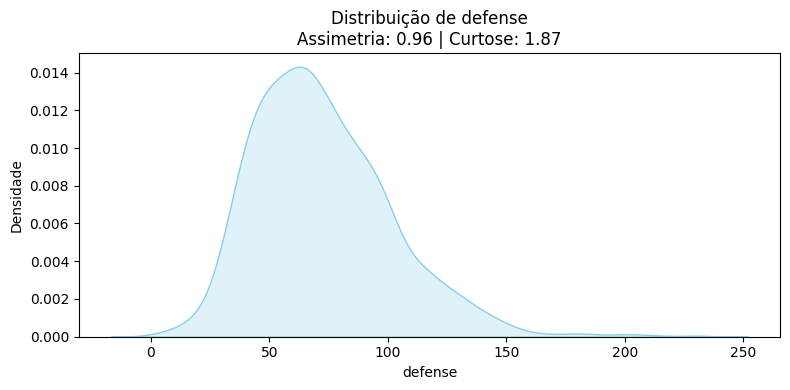

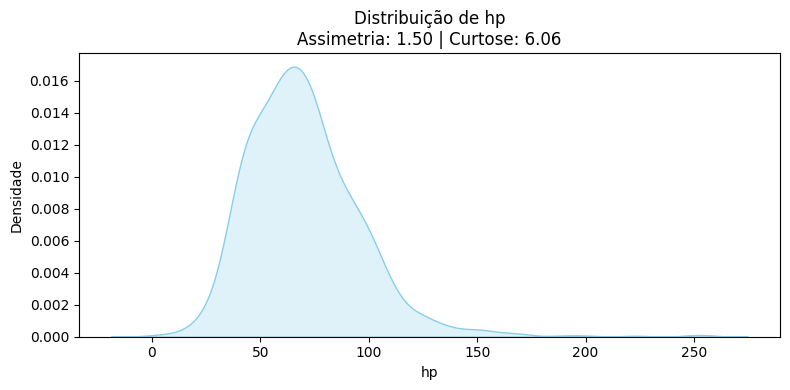

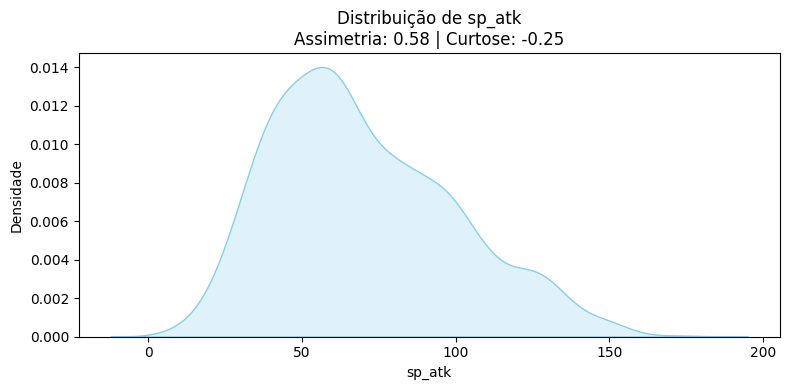

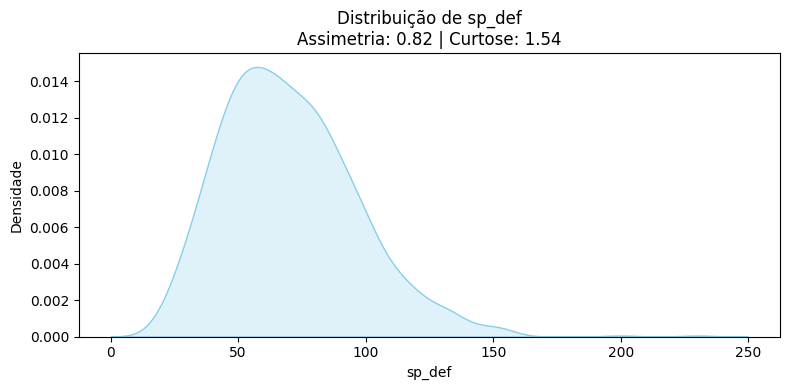

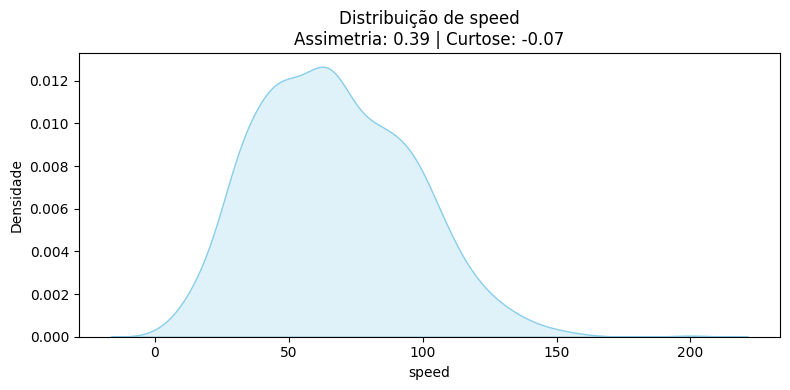

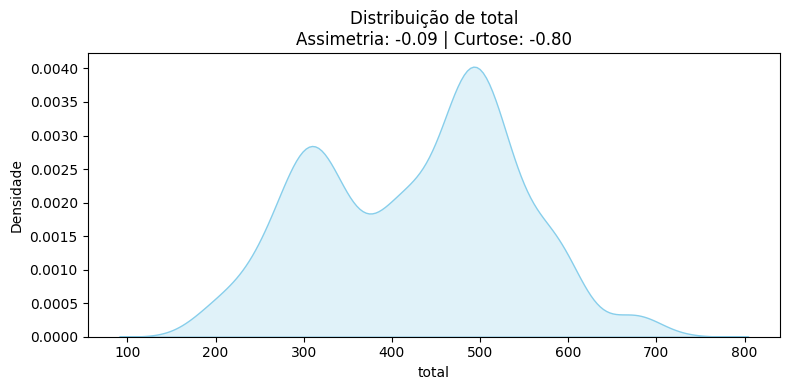

In [27]:
import pandas as pd
import plotly.graph_objects as go
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Seleciona as colunas numéricas
numeric_cols = ['height', 'weight', 'attack', 'defense', 'hp', 'sp_atk', 'sp_def', 'speed', 'total']

# Calcula assimetria (skewness) e curtose para cada atributo
skewness = [skew(basicdf[col].dropna()) for col in numeric_cols]
kurt = [kurtosis(basicdf[col].dropna(), fisher=True) for col in numeric_cols]

# Monta DataFrame para exibição
tabela_assimetria = pd.DataFrame({
    "Atributo": numeric_cols,
    "Assimetria (Skewness)": [f"{v:.2f}" for v in skewness],
    "Curtose": [f"{v:.2f}" for v in kurt]
})

# Exibe a tabela com plotly
fig = go.Figure(data=[go.Table(
    header=dict(values=list(tabela_assimetria.columns), fill_color='paleturquoise', align='left'),
    cells=dict(values=[tabela_assimetria[col] for col in tabela_assimetria.columns], fill_color='lavender', align='left')
)])
fig.update_layout(width=800, height=500, title="Assimetria e Curtose dos Atributos Numéricos dos Pokémon")

# Salva a tabela como imagem
os.makedirs('./charts/skew-kurtosis', exist_ok=True)
fig.write_image('./charts/skew-kurtosis/assimetria_curtose_pokemon.png')
fig.show()


os.makedirs('./charts/skew-kurtosis/curvas', exist_ok=True)

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(basicdf[col].dropna(), fill=True, color='skyblue')
    plt.title(
        f'Distribuição de {col}\n'
        f'Assimetria: {skew(basicdf[col].dropna()):.2f} | Curtose: {kurtosis(basicdf[col].dropna(), fisher=True):.2f}'
    )
    plt.xlabel(col)
    plt.ylabel('Densidade')
    plt.tight_layout()
    plt.savefig(f'./charts/skew-kurtosis/curvas/{col}_curva.png')
    plt.show()

### Análise da Frequência dos Tipos de Pokémon

A distribuição dos tipos de Pokémon é um dos aspectos mais importantes para entender a diversidade e o equilíbrio do universo Pokémon. A seguir, analisamos a frequência dos tipos considerando três cenários:

- **Tipos Primários:**  
  O histograma dos tipos primários mostra quais tipos são mais comuns como o primeiro tipo atribuído a cada Pokémon. Isso reflete a identidade principal de cada espécie e revela tendências de design ao longo das gerações. Tipos como "water", "normal" e "grass" costumam aparecer entre os mais frequentes, enquanto tipos como "ice", "fairy" e "flying" são mais raros como primários.

- **Tipos Secundários:**  
  O histograma dos tipos secundários considera apenas o segundo tipo dos Pokémon que possuem dupla tipagem. Aqui, é possível observar quais tipos são mais utilizados para complementar a tipagem principal, trazendo versatilidade e estratégias diferenciadas para as batalhas. Alguns tipos aparecem com mais frequência como secundários do que como primários, indicando seu papel de suporte ou especialização.

- **Todos os Tipos (Primário + Secundário):**  
  Ao contabilizar todos os tipos presentes em cada Pokémon, temos uma visão geral da popularidade de cada tipo no universo Pokémon. Essa análise evidencia a predominância de certos tipos e a raridade de outros, além de mostrar o impacto da dupla tipagem na diversidade do jogo.

In [23]:
import plotly.express as px
import os

# Garante que a coluna 'type' está como lista
basicdf['type'] = basicdf['type'].apply(lambda x: x if isinstance(x, list) else [])

# Histograma considerando apenas o primeiro tipo de cada Pokémon
basicdf['type_primario'] = basicdf['type'].apply(lambda x: x[0] if len(x) > 0 else None)
freq_primario = basicdf['type_primario'].value_counts().reset_index()
freq_primario.columns = ['Tipo Primário', 'Frequência']

fig1 = px.bar(
    freq_primario,
    x='Tipo Primário',
    y='Frequência',
    title='Frequência dos Tipos Primários dos Pokémon',
    color='Tipo Primário'
)
os.makedirs('./charts/type-frequency', exist_ok=True)
fig1.write_image('./charts/type-frequency/histograma_tipo_primario.png')
fig1.show()

# Histograma considerando apenas o segundo tipo de cada Pokémon (tipos secundários)
basicdf['type_secundario'] = basicdf['type'].apply(lambda x: x[1] if len(x) > 1 else None)
freq_secundario = basicdf['type_secundario'].value_counts().reset_index()
freq_secundario = freq_secundario[freq_secundario['type_secundario'].notnull()]
freq_secundario.columns = ['Tipo Secundário', 'Frequência']

fig2 = px.bar(
    freq_secundario,
    x='Tipo Secundário',
    y='Frequência',
    title='Frequência dos Tipos Secundários dos Pokémon',
    color='Tipo Secundário'
)
fig2.write_image('./charts/type-frequency/histograma_tipo_secundario.png')
fig2.show()

# Explode para cada tipo, mantendo info de primário/secundário
df_types_exploded = basicdf.copy()
df_types_exploded['type_primario'] = df_types_exploded['type'].apply(lambda x: x[0] if len(x) > 0 else None)
df_types_exploded['type_secundario'] = df_types_exploded['type'].apply(lambda x: x[1] if len(x) > 1 else None)

# DataFrame para tipos primários
df_prim = df_types_exploded[['type_primario']].rename(columns={'type_primario': 'type'})
df_prim['Tipo'] = df_prim['type']
df_prim['Posição'] = 'Primário'

# DataFrame para tipos secundários (remover Nones)
df_sec = df_types_exploded[['type_secundario']].rename(columns={'type_secundario': 'type'})
df_sec = df_sec[df_sec['type'].notnull()]
df_sec['Tipo'] = df_sec['type']
df_sec['Posição'] = 'Secundário'

# Junta ambos
df_stack = pd.concat([df_prim, df_sec], ignore_index=True)

# Conta quantos de cada tipo são primários/secundários
freq_stack = df_stack.groupby(['Tipo', 'Posição']).size().reset_index(name='Frequência')

# Ordena tipos pelo total de ocorrências (primário+secundário)
tipo_ordem = freq_stack.groupby('Tipo')['Frequência'].sum().sort_values(ascending=False).index.tolist()

fig_stack = px.bar(
    freq_stack,
    x='Tipo',
    y='Frequência',
    color='Posição',
    category_orders={'Tipo': tipo_ordem, 'Posição': ['Primário', 'Secundário']},
    barmode='stack',
    title='Frequência de Todos os Tipos dos Pokémon (Primário x Secundário - Empilhado)'
)
fig_stack.write_image('./charts/type-frequency/histograma_todos_tipos_stacked.png')
fig_stack.show()

### Análise dos Status Médios por Tipo de Pokémon

A seguir, apresentamos os três tipos de Pokémon com as maiores médias em cada atributo de status, acompanhados da respectiva margem de erro (intervalo de confiança de 95%). Esses dados ajudam a identificar quais tipos se destacam em cada aspecto de batalha.

#### Top 3 Tipos por Status

| Status         | 1º Tipo   | Média   | Margem de Erro | 2º Tipo   | Média   | Margem de Erro | 3º Tipo   | Média   | Margem de Erro |
|----------------|-----------|---------|----------------|-----------|---------|----------------|-----------|---------|----------------|
| **Attack**     | Fighting  | 104.33  | ±5.81          | Dragon    | 94.00   | ±6.34          | Dark      | 93.59   | ±6.07          |
| **Defense**    | Steel     | 107.88  | ±8.25          | Rock      | 103.53  | ±8.96          | Ground    | 85.45   | ±7.53          |
| **HP**         | Dragon    | 84.07   | ±7.69          | Ice       | 80.08   | ±7.72          | Fighting  | 77.75   | ±5.43          |
| **Sp. Atk**    | Psychic   | 88.04   | ±6.11          | Dragon    | 87.20   | ±8.04          | Fire      | 86.31   | ±6.25          |
| **Sp. Def**    | Psychic   | 84.20   | ±5.13          | Fairy     | 83.92   | ±7.87          | Ghost     | 79.09   | ±6.88          |
| **Speed**      | Flying    | 82.43   | ±4.29          | Electric  | 81.87   | ±7.96          | Dragon    | 78.17   | ±6.66          |
| **Total**      | Dragon    | 504.76  | ±29.19         | Steel     | 479.72  | ±24.80         | Fighting  | 467.14  | ±23.15         |

- **Fighting** lidera em ataque, enquanto **Steel** domina em defesa.
- **Dragon** aparece entre os três melhores em ataque, HP, ataque especial, velocidade **e também possui o maior total médio de atributos** (504.76 ±29.19), mostrando sua versatilidade e força geral.
- **Steel** além de ser o melhor em defesa, também está entre os maiores totais médios (479.72 ±24.80), indicando Pokémon geralmente bem equilibrados e resistentes.
- **Fighting** destaca-se em ataque e também figura entre os maiores totais médios (467.14 ±23.15), reforçando seu perfil ofensivo.
- **Psychic** é destaque em ataque especial e defesa especial.
- **Flying** e **Electric** são os tipos mais rápidos, com médias de velocidade superiores aos demais.

In [24]:
import plotly.express as px

# Explode o DataFrame para que cada tipo de Pokémon fique em uma linha
df_exploded = basicdf.explode('type')

# Seleciona os atributos de interesse
atributos = ['attack', 'defense', 'hp', 'sp_atk', 'sp_def', 'speed', 'total']

for atributo in atributos:
    # Ordena os tipos pela média do atributo (do maior para o menor)
    ordem_tipos = (
        df_exploded.groupby('type')[atributo]
        .mean()
        .sort_values(ascending=False)
        .index.tolist()
    )
    fig = px.box(
        df_exploded,
        x='type',
        y=atributo,
        category_orders={'type': ordem_tipos},
        points="all",
        title=f'Distribuição de {atributo.capitalize()} por Tipo de Pokémon',
        labels={'type': 'Tipo', atributo: atributo.capitalize()}
    )
    fig.update_layout(width=1000, height=500)
    os.makedirs('./charts/stats-per-type', exist_ok=True)
    fig.write_image(f'./charts/stats-per-type/boxplot_{atributo}_por_tipo.png')
    fig.show()

### Insights sobre a Distribuição de Pokémon por Local de Captura

A análise dos novos gráficos e da tabela descritiva revela pontos importantes sobre a distribuição dos Pokémon nos diferentes locais de captura:

- **Distribuição Desigual:** O gráfico de dispersão mostra que a maioria dos locais de captura possui uma quantidade pequena de espécies de Pokémon disponíveis, enquanto poucos locais concentram uma grande diversidade. Isso indica uma distribuição desigual, com muitos locais "exclusivos" ou pouco povoados e poucos "hubs" de alta diversidade.

- **Moda, Mediana e Média:** A moda e a mediana da quantidade de Pokémon por local são significativamente menores que a média, reforçando que a maior parte dos locais tem poucos Pokémon, mas alguns locais com muitos Pokémon elevam a média geral.

- **Locais de Alta Diversidade:** Os poucos locais que aparecem no topo do gráfico de barras são pontos estratégicos para jogadores que desejam encontrar uma grande variedade de espécies, sendo ideais para completar a Pokédex de forma eficiente.

- **Top 5 Pokémon com Maior Número de Locais Capturáveis:**
    - **Magikarp**: encontrado em 244 locais diferentes, presente em praticamente todas as regiões aquáticas.
    - **Golbat**: aparece em 142 locais, sendo comum em cavernas e rotas.
    - **Gyarados**: disponível em 132 locais, geralmente em áreas de água e lagos.
    - **Zubat**: presente em 125 locais, típico de cavernas e túneis.
    - **Tentacool**: encontrado em 113 locais, principalmente em mares e áreas costeiras.

In [28]:
import plotly.express as px
import os

# Explode a coluna 'capture_location' para que cada local ocupe uma linha
df_locais = basicdf.explode('capture_location')

# Remove valores nulos/vazios
df_locais = df_locais[df_locais['capture_location'].notnull() & (df_locais['capture_location'] != '')]

# Conta a frequência de cada local de captura
freq_locais = df_locais['capture_location'].value_counts().reset_index()
freq_locais.columns = ['Local de Captura', 'Frequência']

# Top 20 pokémons com maior número de locais capturáveis
basicdf['num_locais'] = basicdf['capture_location'].apply(lambda x: len(x) if isinstance(x, list) else 0)
top20 = basicdf.sort_values('num_locais', ascending=False)[['name', 'num_locais']].head(20)

fig = px.bar(
    top20,
    x='name',
    y='num_locais',
    title='Top 20 Pokémon com Maior Número de Locais Capturáveis',
    labels={'name': 'Pokémon', 'num_locais': 'Nº de Locais Capturáveis'},
    color='num_locais',
    color_continuous_scale='Blues'
)
fig.update_layout(xaxis_tickangle=45, width=900, height=500)
os.makedirs('./charts/capture-regions', exist_ok=True)
fig.write_image('./charts/capture-regions/top20_pokemons_locais_captura.png')
fig.show()

# Gera o histograma dos 20 locais mais frequentes
fig = px.bar(
    freq_locais.head(20),
    x='Local de Captura',
    y='Frequência',
    title='Top 20 Locais de Captura Com Maior Diversidade de Pokémon',
    color='Local de Captura'
)
fig.update_layout(xaxis_tickangle=45, width=1000, height=500)
fig.write_image('./charts/capture-regions/histograma_top20_locais_captura.png')
fig.show()

# Gráfico de dispersão da quantidade de Pokémon por local de captura (todas as áreas)
fig_disp = px.histogram(
    freq_locais,
    x='Frequência',
    nbins=30,
    title='Distribuição da Quantidade de Pokémon por Local de Captura',
    labels={'Frequência': 'Quantidade de Pokémon no Local'}
)
fig_disp.update_layout(width=900, height=400)
fig_disp.write_image('./charts/capture-regions/dispersao_pokemons_por_local.png')
fig_disp.show()

# Estatísticas descritivas

# freq_locais já contém a contagem de pokémons por local de captura
freq_locais.columns = ['Local de Captura', 'Frequência']
desc_stats = {
    "Média": freq_locais['Frequência'].mean(),
    "Mediana": freq_locais['Frequência'].median(),
    "Moda": freq_locais['Frequência'].mode().iloc[0] if not freq_locais['Frequência'].mode().empty else np.nan,
    "Mínimo": freq_locais['Frequência'].min(),
    "Máximo": freq_locais['Frequência'].max(),
    "Desvio Padrão": freq_locais['Frequência'].std(),
    "Total de Locais": freq_locais.shape[0]
}

# Monta a tabela para exibição
tabela = pd.DataFrame({
    "Estatística": list(desc_stats.keys()),
    "Valor": [f"{v:.2f}" if isinstance(v, float) else v for v in desc_stats.values()]
})

# Exibe a tabela com plotly
fig = go.Figure(data=[go.Table(
    header=dict(values=["Estatística", "Valor"], fill_color='paleturquoise', align='left'),
    cells=dict(values=[tabela['Estatística'], tabela['Valor']], fill_color='lavender', align='left')
)])
fig.update_layout(width=600, height=400, title="Estatísticas - Pokémon por Local de Captura")
fig.write_image('./charts/capture-regions/estatisticas_locais_captura.png')
fig.show()

# Gráfico: Locais de captura com maior média de total dos pokémons daquela área
media_total_por_local = (
    df_locais.groupby('capture_location')['total']
    .mean()
    .reset_index()
    .rename(columns={'capture_location': 'Local de Captura', 'total': 'Média Total'})
    .sort_values('Média Total', ascending=False)
)

# Exibe apenas locais com pelo menos 5 pokémons diferentes para evitar viés de locais raros
locais_com_mais_de_5 = freq_locais[freq_locais['Frequência'] >= 5]['Local de Captura']
media_total_por_local_filtrado = media_total_por_local[media_total_por_local['Local de Captura'].isin(locais_com_mais_de_5)]

fig_media_total = px.bar(
    media_total_por_local_filtrado.head(20),
    x='Local de Captura',
    y='Média Total',
    title='Top 20 Locais de Captura com Maior Média de Total dos Pokémon',
    color='Média Total',
    color_continuous_scale='Viridis'
)
fig_media_total.update_layout(xaxis_tickangle=45, width=1100, height=500)
fig_media_total.write_image('./charts/capture-regions/top20_locais_maior_media_total.png')
fig_media_total.show()



### Matriz de Correlação entre Atributos Numéricos dos Pokémon

- **total × outros atributos:**  
  O atributo "total" apresenta alta correlação com todos os atributos individuais, especialmente ataque, defesa, HP e ataque especial, pois é a soma direta desses valores.

- **height × weight (0.63):**  
  Altura e peso têm uma correlação forte, como esperado, já que Pokémon mais altos tendem a ser mais pesados.

- **speed × outros atributos:**  
  Velocidade apresenta correlação mais baixa com os demais atributos, indicando que ser rápido não necessariamente significa ter outros atributos altos.

- **sp_atk e sp_def:**  
  A correlação entre defesa especial e defesa é moderada, enquanto a correlação entre ataque especial e ataque é fraca. 

**Resumo:**  
A matriz revela que Altura e Peso tem relação, assim como defesa especial e defesa. Já velocidade é um atributo mais "independente", variando bastante entre Pokémon de diferentes perfis.

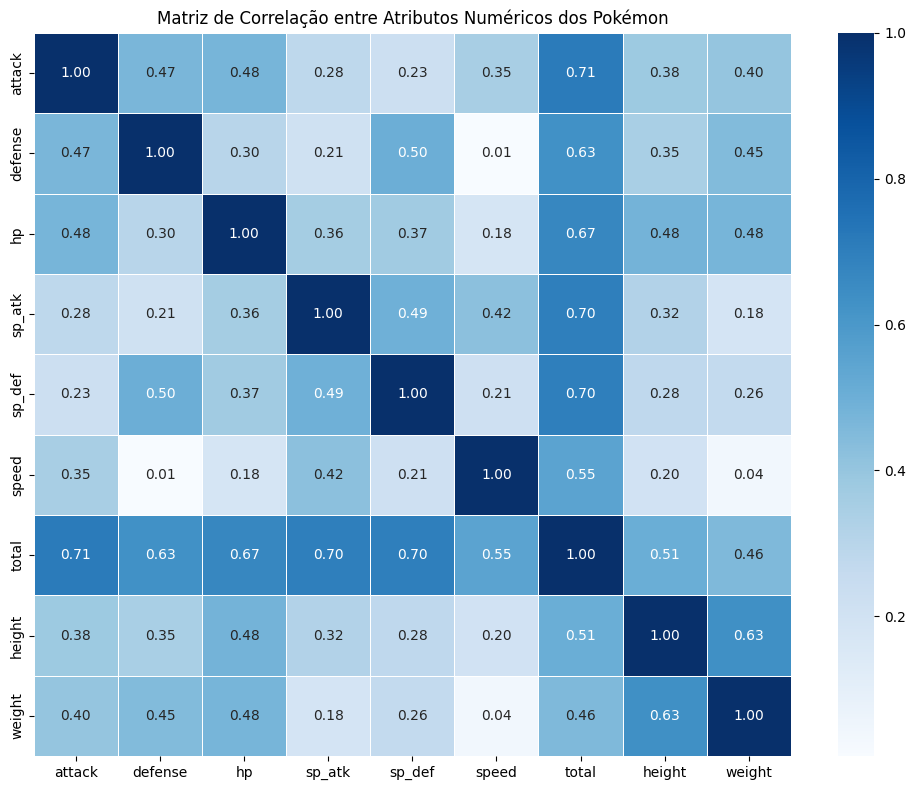

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Seleciona apenas as colunas numéricas relevantes
numeric_cols = ['attack', 'defense', 'hp', 'sp_atk', 'sp_def', 'speed', 'total', 'height', 'weight']

# Calcula a matriz de correlação
corr_matrix = basicdf[numeric_cols].corr()

# Exibe a matriz de correlação como um heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".2f", linewidths=0.5)
plt.title('Matriz de Correlação entre Atributos Numéricos dos Pokémon')
plt.tight_layout()
os.makedirs('./charts/stats-correlation', exist_ok=True)
plt.savefig('./charts/stats-correlation/matriz_correlacao_pokemon.png')
plt.show()

## Analises com Inteligência Artificial

### Montagem de Time Ideal com Algoritmo Genético

Nesta etapa, aplicamos um **Algoritmo Genético (GA)** para otimizar a montagem de um time ideal de Pokémon. Essa abordagem é inspirada na evolução natural e consiste em simular um processo de seleção e reprodução de times com o objetivo de encontrar a melhor combinação possível.

---

#### Objetivo

Selecionar **6 pokémons ideais** a partir de uma amostra aleatória da base, considerando critérios como:

- **Diversidade de Tipos (Critério Primário)**:
   - **Objetivo**: Evitar sobreposição de tipos e maximizar cobertura ofensiva/defensiva.
   - **Métricas**:
      - +2 pontos por tipo único no time
      - Bônus se cobrir todos os 18 tipos elementares
      - Penalizar times com >2 Pokémon do mesmo tipo
- **Cobertura de Fraquezas (Critério Defensivo)**:
   - **Objetivo**: Garantir que toda fraqueza do time seja neutralizada por outro membro.
   - **Métricas**:
      - +1 ponto por fraqueza coberta (ex: Se um Pokémon é fraco contra Água, outro deve resistir a Água)
      - Penalidade para fraquezas descobertas (ex: Time com 3 Pokémon fracos contra Pedra sem resistência)
- **Balanceamento de Atributos (Critério de Combate)**:
   - **Objetivo**: Distribuição equilibrada de funções táticas. Esta parte é realizada por um processo de clusterização utilizando o algoritmo de K-means para realizar a categorização dos grupos baseados nos atributos de combate.
   - **Tipo de clusterização utilizada**:

   | Cluster | Atributos-Chave | Função                      |
   |----------------|---------------------|--------------------------------|
   | 0           | Alto attack / speed                   | Atacante Físico       |
   | 1           | Alto sp_atk / sp_def                   | Atacante Especial          |
   | 2         | Alto defense / hp                   | Tanque |
   | 3       | Balanceado                   |           All-Rounder                     |

   - **Pontuação**:
      - +1.5 pontos por cluster dentro do time.

---

#### Etapas do Algoritmo Genético

1. **Inicialização**  
   Geração de uma população inicial de times aleatórios (indivíduos).

2. **Avaliação (Fitness)**  
   Cada time recebe uma pontuação com base nos critérios mencionados acima.

3. **Seleção**  
   Os melhores times da população são selecionados como "pais" para gerar a próxima geração.

4. **Cruzamento (Crossover)**  
   Combinações de times (pais) são misturadas para formar novos times (filhos), tentando herdar as melhores características de ambos.

5. **Mutação**  
   Com uma pequena chance, um pokémon aleatório do time é substituído para aumentar a diversidade da população.

6. **Iterações**  
   O processo é repetido por várias gerações até que o time ideal seja encontrado (ou o número máximo de gerações seja atingido).

---

#### Visualização

Ao final, os atributos dos pokémons do time ideal são visualizados em gráficos do tipo **radar plot**, permitindo comparar peso e altura entre os integrantes da equipe.

---

#### Justificativa do Método

O uso de algoritmos genéticos permite simular uma otimização multiobjetivo de forma simples e intuitiva. Apesar de não ser determinístico (pode gerar resultados diferentes a cada execução), ele é muito útil para problemas de **busca em espaço combinatório**, como a seleção ótima de pokémons em um conjunto com muitas possibilidades.

---

#### Conclusão

O time ideal gerado por este algoritmo apresenta:

- Boa cobertura de tipos e fraquezas.
- Equilíbrio nos atributos físicos.
- Diversidade estratégica.

Essa abordagem mostra como técnicas de Inteligência Artificial podem ser aplicadas para resolver problemas inspirados em jogos e tomadas de decisão complexas.


### Etapas do processo

- **Inicialização e Clusterização por atributos de combate**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

df_cluster = basicdf.copy()

# Clusterização por atributos de combate
combat_features = ['attack', 'defense', 'sp_atk', 'sp_def', 'speed', 'hp']
scaler = StandardScaler()
combat_clusters = scaler.fit_transform(df_cluster[combat_features])
kmeans = KMeans(n_clusters=4, random_state=42)
df_cluster['combat_role'] = kmeans.fit_predict(combat_clusters)

# Mapeamento dos clusters para os papéis de combate
role_mapping = {
    0: "Atacante Físico",
    1: "Atacante Especial",
    2: "Tanque",
    3: "All-Rounder"
}

df_cluster['combat_role'] = df_cluster['combat_role'].map(role_mapping)

# Impressão de exemplos do dataframe com os clusters de combate para cada pokemon
df_cluster[['name', 'combat_role']].head(10)

Esta célula realiza a clusterização dos Pokémon com base em seus atributos de combate, para categorizar cada um em um papel tático (role) que será usado na montagem do time ideal.

**Passos realizados:**

1. **Cópia do DataFrame:**  
   Cria-se uma cópia do DataFrame principal (`basicdf`) chamada `df_cluster` para não alterar os dados originais.

2. **Seleção dos atributos de combate:**  
   São escolhidas as colunas `['attack', 'defense', 'sp_atk', 'sp_def', 'speed', 'hp']` para representar o perfil de combate de cada Pokémon.

3. **Padronização dos dados:**  
   Os valores desses atributos são padronizados usando `StandardScaler`, garantindo que todos tenham média 0 e desvio padrão 1, o que é importante para a clusterização.

4. **Clusterização KMeans:**  
   Utiliza-se o algoritmo KMeans para dividir os Pokémon em 4 clusters (grupos), cada um representando um papel de combate diferente.

5. **Mapeamento dos clusters para papéis táticos:**  
   Cada cluster é associado a um papel:
   - 0: Atacante Físico
   - 1: Atacante Especial
   - 2: Tanque
   - 3: All-Rounder (equilibrado)

6. **Atribuição do papel ao DataFrame:**  
   O resultado da clusterização é salvo na coluna `combat_role` do DataFrame, já com o nome do papel correspondente.

7. **Exemplo de saída:**  
   Exibe as 10 primeiras linhas do DataFrame mostrando o nome do Pokémon e seu papel de combate.

- **Criação da função de avaliação(Fitness)**

In [ ]:
def evaluate_team(team_indices, df):
    team = df.iloc[team_indices]
    
    # 1. Diversidade de Tipos
    unique_types = set()
    for types in team['type']:
        unique_types.update(types)
    type_score = 2 * len(unique_types)
    
    # 2. Cobertura de Fraquezas
    all_weaknesses = set()
    covered_weaknesses = set()
    for weaknesses in team['weakness']:
        all_weaknesses.update(weaknesses)
    
    for weakness in all_weaknesses:
        for _, member in team.iterrows():
            if weakness not in member['weakness']:
                covered_weaknesses.add(weakness)
                break
                
    weakness_score = len(covered_weaknesses)
    
    # 3. Balanceamento de Roles
    role_score = 1.5 * len(set(team['combat_role']))
    
    # 4. Penalidade por sobreposição de tipos
    overlap_penalty = 0
    type_counts = {}
    for types in team['type']:
        for t in types:
            type_counts[t] = type_counts.get(t, 0) + 1
    for t, count in type_counts.items():
        if count > 2:
            overlap_penalty += 2 * (count - 2)
    
    total_score = type_score + weakness_score + role_score - overlap_penalty
    
    return total_score,


Esta célula define a função `evaluate_team`, responsável por calcular a pontuação (fitness) de um time de Pokémon para o algoritmo genético. Ela avalia o quão "bom" é um time de acordo com critérios estratégicos. Veja como funciona cada parte:

- **Parâmetros:**  
  - `team_indices`: lista de índices dos Pokémon que compõem o time.
  - `df`: DataFrame contendo os dados dos Pokémon.

- **Processo de avaliação:**
  1. **Diversidade de Tipos:**  
     Soma 2 pontos para cada tipo único presente no time, incentivando variedade de tipos.
  2. **Cobertura de Fraquezas:**  
     Para cada fraqueza presente no time, verifica se há pelo menos um membro que não compartilha essa fraqueza (ou seja, pode cobri-la). Soma 1 ponto para cada fraqueza coberta.
  3. **Balanceamento de Roles:**  
     Soma 1.5 pontos para cada papel de combate (`combat_role`) diferente presente no time, incentivando diversidade tática.
  4. **Penalidade por Sobreposição de Tipos:**  
     Para cada tipo que aparece mais de duas vezes no time, aplica uma penalidade proporcional ao excesso, desestimulando times repetitivos.

- **Retorno:**  
  Retorna a pontuação total do time como uma tupla (exigência da biblioteca DEAP).

- **Criação do Algoritmo Genético**

In [ ]:
from deap import base, creator, tools, algorithms
import random

# Configuração do Algoritmo Genético
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("indices", random.sample, range(len(df_cluster)), 6)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate_team, df=df_cluster)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=0, up=len(df_cluster)-1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

pop = toolbox.population(n=50)

Esta célula configura o algoritmo genético utilizando a biblioteca DEAP para buscar o time ideal de Pokémon.

**Passos realizados:**

1. **Importação das bibliotecas:**  
   Importa os módulos necessários da DEAP e a biblioteca `random`.

2. **Definição dos tipos de indivíduo e fitness:**  
   - Cria uma classe de fitness para maximização (`FitnessMax`).
   - Cria uma classe de indivíduo baseada em lista, associada ao fitness criado.

3. **Configuração do toolbox:**  
   - Define como gerar um indivíduo: seleciona aleatoriamente 6 índices de Pokémon do DataFrame `df_cluster`.
   - Define como criar a população: repete o processo de criação de indivíduos.
   - Registra as funções de avaliação (`evaluate_team`), cruzamento (`cxTwoPoint`), mutação (`mutUniformInt`) e seleção (`selTournament`).

4. **Geração da população inicial:**  
   Cria uma população de 50 times (indivíduos), cada um composto por 6 Pokémon aleatórios.

- **Análise da população inicial de pokemons escolhida aleatoriamente**

In [ ]:
def analyze_population(population, df, n_samples=5):
    print(f"\n=== ANÁLISE DA POPULAÇÃO INICIAL ({len(population)} indivíduos) ===")
    
    # Mostrar alguns exemplos
    print(f"\nExemplos de {n_samples} times iniciais:")
    for i in range(min(n_samples, len(population))):
        team = df.iloc[population[i]]
        print(f"\nTime {i+1}:")
        print(team[['name', 'type', 'combat_role']].to_markdown())
        print("Score:", evaluate_team(population[i], df)[0])
    
    # Estatísticas da população
    roles_dist = []
    type_counts = []
    weakness_coverage = []
    
    for ind in population:
        team = df.iloc[ind]
        roles_dist.extend(team['combat_role'].tolist())
        type_counts.append(len(set().union(*team['type'])))
        
        weaknesses = set().union(*team['weakness'])
        covered = sum(1 for w in weaknesses 
                     if any(w not in m_weak for m_weak in team['weakness']))
        weakness_coverage.append(covered)
    
    print("\n● Distribuição geral de roles:")
    print(pd.Series(roles_dist).value_counts())
    
    print("\n● Média de tipos únicos por time:", np.mean(type_counts))
    print("● Média de fraquezas cobertas por time:", np.mean(weakness_coverage))

analyze_population(pop, df_cluster)

Esta célula define e executa a função `analyze_population`, que faz uma análise exploratória da população inicial de times gerados aleatoriamente pelo algoritmo genético.

**O que a função faz:**

1. **Exibe exemplos de times:**  
   Mostra detalhes de alguns times iniciais (nome, tipos e papel de combate de cada Pokémon), além da pontuação (score) de cada time segundo a função de avaliação.

2. **Estatísticas da população:**  
   - **Distribuição de roles:** Conta quantos papéis de combate (roles) aparecem na população total.
   - **Média de tipos únicos por time:** Calcula a média de tipos diferentes presentes em cada time.
   - **Média de fraquezas cobertas por time:** Mede, em média, quantas fraquezas são cobertas dentro dos times.


- **Execução**

In [ ]:
# Execução
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("max", np.max)

result, log = algorithms.eaSimple(
    pop, toolbox, cxpb=0.7, mutpb=0.2, ngen=50,
    stats=stats, halloffame=hof, verbose=True
)


Esta célula executa o processo evolutivo do algoritmo genético para encontrar o time ideal de Pokémon.

**Passos realizados:**

1. **Criação do Hall of Fame:**  
   Um objeto `HallOfFame` é criado para armazenar o melhor indivíduo (time) encontrado durante a evolução.

2. **Configuração das estatísticas:**  
   Um objeto `Statistics` é configurado para registrar a média (`avg`) e o valor máximo (`max`) do fitness da população a cada geração.

3. **Execução do algoritmo genético:**  
   A função `algorithms.eaSimple` executa o ciclo evolutivo por 50 gerações, aplicando cruzamento, mutação, avaliação e seleção, enquanto registra as estatísticas e atualiza o Hall of Fame.

- **Resultados**

In [ ]:
# Resultados
best_team = df_cluster.iloc[hof[0]]
print("=== MELHOR TIME ===")
print(best_team[['name', 'type', 'weakness', 'combat_role']].to_markdown())

# Análise
print(f"\nTipos únicos: {len(set().union(*best_team['type']))}")
print(f"Fraquezas cobertas: {len(set().union(*best_team['weakness']))}")
print("Distribuição de roles:")
print(best_team['combat_role'].value_counts())

# Visualização
attributes = ['attack','defense','sp_atk','sp_def','speed','hp']
team_stats = best_team[attributes].values
team_stats_normalized = team_stats / team_stats.max(axis=0)

angles = np.linspace(0, 2*np.pi, len(attributes), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8,8), subplot_kw={'polar': True})
for i in range(len(best_team)):
    values = team_stats_normalized[i].tolist()
    values += values[:1]
    ax.plot(angles, values, label=best_team.iloc[i]['name'])
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(attributes)
ax.set_title('Atributos do Time', pad=20)
ax.legend(bbox_to_anchor=(1.3, 1))
plt.show()

Esta célula apresenta e analisa o melhor time de Pokémon encontrado pelo algoritmo genético após o processo evolutivo.

**O que é exibido:**

1. **Melhor time:**  
   Mostra uma tabela com os nomes, tipos, fraquezas e papéis de combate dos 6 Pokémon selecionados como o time ideal.

2. **Análise do time:**  
   - Quantidade de tipos únicos presentes no time.
   - Quantidade de fraquezas cobertas.
   - Distribuição dos papéis de combate (roles) entre os membros do time.

3. **Visualização dos atributos:**  
   Gera um gráfico radar (radar plot) comparando os principais atributos de combate (`attack`, `defense`, `sp_atk`, `sp_def`, `speed`, `hp`) dos integrantes do time, permitindo visualizar o equilíbrio e a diversidade dos Pokémon escolhidos.
